This notebook generates a prompt prefix for every task. Prompt prefix consists of instruction and demonstrations.

The instruction is obtained from [PromptSource](https://github.com/bigscience-workshop/promptsource) using the notebook `get_instructions.ipynb`, and then manually filtered.

The demonstrations are sampled from the `dev` split.

# See statistics of each tasks

In [11]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from transformers import T5Tokenizer

CLF_TASKS = [
    "emo", "emotion", "tweet_eval-emoji", "tweet_eval-emotion", "tweet_eval-hate", "tweet_eval-irony", "tweet_eval-offensive", 
    "tweet_eval-sentiment", "tweet_eval-stance_abortion", "tweet_eval-stance_atheism", "tweet_eval-stance_climate", 
    "tweet_eval-stance_feminist", "tweet_eval-stance_hillary", "climate_fever", "health_fact", "kilt_fever", "liar", "tab_fact", 
    "ethos-directed_vs_generalized", "ethos-disability", "ethos-gender", "ethos-national_origin", "ethos-race", "ethos-religion", 
    "ethos-sexual_orientation", "hate_speech_offensive", "hate_speech18", "hatexplain", "anli", "glue-mnli", "glue-qnli", 
    "glue-rte", "glue-wnli", "scitail", "sick", "superglue-cb", "superglue-rte", "ade_corpus_v2-classification", "circa", 
    "discovery", "glue-cola", "google_wellformed_query", "onestop_english", "scicite", "sms_spam", "superglue-wic", "superglue-wsc", 
    "trec", "trec-finegrained", "wiki_auto", "wiki_qa", "glue-mrpc", "glue-qqp", "medical_questions_pairs", "paws", 
    "amazon_polarity", "financial_phrasebank", "glue-sst2", "imdb", "poem_sentiment", "rotten_tomatoes", "yelp_polarity", "ag_news", 
    "dbpedia_14", "yahoo_answers_topics"]  # All 65 classification tasks.
TASK_NAMES = CLF_TASKS
T5_MODEL = "t5-base"
MAX_INPUT_LEN = 1024


def get_task_prefixes(data_path: str, task_name: str) -> list:
    """Returns all task prefixes (e.g., adversarialqa_32_13) of a task."""
    files = sorted(os.listdir(os.path.join(data_path, task_name)))
    prefixes = []
    for filename in files:
        if not filename.endswith(".tsv"):
            continue
        prefix = "_".join(filename.split("_")[:-1])
        if prefix not in prefixes:
            prefixes.append(prefix)
    return prefixes

def get_all_examples(task_name: str) -> list:
    examples = []
    count = {}
    prefix = get_task_prefixes("data/crossfit", task_name)[0]
    for split in ["train", "dev", "test"]:
        suffix = "_" + split + ".tsv"
        with open(os.path.join("data/crossfit", task_name, prefix + suffix)) as fin:
            lines = fin.readlines()
        for line in lines:
            d = line.strip().split("\t")
            examples.append([d[0], d[1:]])
        count[split] = len(lines)
    return examples, count

tokenizer = T5Tokenizer.from_pretrained(T5_MODEL, model_max_length=MAX_INPUT_LEN)

data = []
for task_name in TASK_NAMES:
    examples, count = get_all_examples(task_name)
    tokenized_input = tokenizer([ex[0] for ex in examples])
    tokenized_target = tokenizer([x for ex in examples for x in ex[1]])
    lengths = [len(x) for x in tokenized_input["input_ids"]]
    max_target_len = np.max([len(x) for x in tokenized_target["input_ids"]])

    data.append([
        task_name, len(examples), count["train"], count["dev"], count["test"], max_target_len, np.min(lengths), np.max(lengths),
        np.percentile(lengths, 25), np.percentile(lengths, 50), np.percentile(lengths, 75), lengths
    ])

stats_df = pd.DataFrame(data,
                        columns=["task_name", "n_examples", "n_train", "n_dev", "n_test", "max_target_len",
                                 "min_len", "max_len", "percentile25", "percentile50", "percentile75", "all_lengths"])

with pd.option_context("display.max_rows", None, "display.max_columns", None):
    display(stats_df[[
        "task_name", "n_examples", "n_train", "n_dev", "n_test", "max_target_len",
        "min_len", "max_len", "percentile25", "percentile50", "percentile75"]])

,task_name,n_examples,n_train,n_dev,n_test,max_target_len,min_len,max_len,percentile25,percentile50,percentile75
0,emo,5637,64,64,5509,2,4,222,15.0,20.0,25.00
1,emotion,2192,96,96,2000,2,5,90,16.0,24.0,34.00
2,tweet_eval-emoji,5640,320,320,5000,3,5,56,17.0,23.0,30.00
3,tweet_eval-emotion,502,64,64,374,2,6,71,20.0,31.0,39.00
4,tweet_eval-hate,1063,32,32,999,2,5,158,27.0,39.0,59.00
5,tweet_eval-irony,1019,32,32,955,47,4,66,18.0,26.0,34.00
6,tweet_eval-offensive,1388,32,32,1324,2,6,150,20.0,34.0,56.00
7,tweet_eval-sentiment,2096,48,48,2000,2,9,100,28.0,34.0,40.00
8,tweet_eval-stance_abortion,162,48,48,66,4,16,64,29.0,36.0,42.00
9,tweet_eval-stance_atheism,148,48,48,52,4,15,57,32.0,37.0,42.00


In [10]:
# These are 6 classification tasks which are removed (due to the long input).
# We will use 4 and 8 demonstrations in the prompt. In case of 4 demonstrations,
# "amazon_polarity", "yahoo_answers_topics", and "yelp_polarity" can be used.
stats_df[(stats_df.percentile75 > 120)][[
        "task_name", "n_examples", "n_train", "n_dev", "n_test", "max_target_len", "min_len", "max_len",
        "percentile25", "percentile50", "percentile75"]]
# We also remove "tweet_eval-emoji" because T5 cannot recognize the emojis.


,task_name,n_examples,n_train,n_dev,n_test,max_target_len,min_len,max_len,percentile25,percentile50,percentile75
17,tab_fact,12856,32,32,12792,4,103,3551,282.0,427.0,675.00
42,onestop_english,210,48,48,114,2,337,1918,744.5,879.0,1043.25
55,amazon_polarity,1064,32,32,1000,2,27,322,62.0,100.0,155.25
58,imdb,25064,32,32,25000,797,11,3607,184.0,258.0,423.00
61,yelp_polarity,7664,32,32,7600,2,4,1284,73.0,134.0,244.00
64,yahoo_answers_topics,60320,160,160,60000,71,14,3082,59.0,103.0,182.00


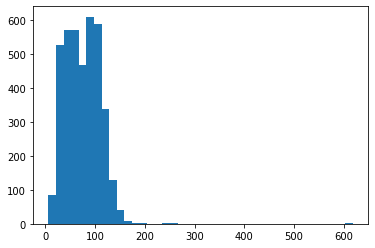

In [4]:
def plot_hist(task_name, n_bins=40):
    n, bins, patches = plt.hist(stats_df[stats_df.task_name == task_name].iloc[0]["all_lengths"], n_bins)
    plt.show()

plot_hist("dbpedia_14")

# Generate prompt prefix

In [26]:
TASK_NAMES = [x for x in CLF_TASKS if x not in [
    "amazon_polarity", "imdb", "onestop_english", "tab_fact", "tweet_eval-emoji", "yahoo_answers_topics", "yelp_polarity"]]
T5_MODEL = "t5-base"
MAX_INPUT_LEN = 1024
K = 8  # Number of demonstrations.
INSTRUCTIONS_FILE = "data/prompt/instructions_iosep.tsv"
OUTPUT_FILE = "data/prompt/prompt.tsv"


# Read instructions data.
INSTRUCTIONS_DICT = {}
with open(INSTRUCTIONS_FILE) as fin:
    lines = fin.readlines()
for line in lines:
    splits = line.strip().split("\t")  # Splits into (task_name, instruction, input_output_separator).
    INSTRUCTIONS_DICT[splits[0]] = splits[1], splits[2]

In [27]:
import random
random.seed(0)

data = []
for task_name in TASK_NAMES:
    prefixes = get_task_prefixes("data/crossfit", task_name)
    for prefix in prefixes:
        # Get dev examples
        dev_examples = []
        with open(os.path.join("data/crossfit", task_name, prefix + "_dev.tsv")) as fin:
            lines = fin.readlines()
        for line in lines:
            d = line.strip().split("\t")
            dev_examples.append([d[0], d[1:]])

        # Construct prompt with demos and instructions
        demos = random.sample(dev_examples, K)
        instructions, iosep = INSTRUCTIONS_DICT[task_name]
        demos_text = " ".join(["{} {} {}".format(ex[0], iosep, random.choice(ex[1])) for ex in demos])
        prompt = instructions + " " + demos_text

        data.append([
            task_name, prefix, prompt, len(tokenizer(prompt)["input_ids"]), iosep
        ])

prompt_df = pd.DataFrame(
    data, columns=["task_name", "task_prefix", "prompt", "prompt_len", "io_sep"])
with pd.option_context("display.max_rows", None, "display.max_columns", None):
    display(prompt_df)

,task_name,task_prefix,prompt,prompt_len,io_sep
0,emo,emo_16_100,What would you say is the underlying emotion o...,209,emotion:
1,emo,emo_16_13,What would you say is the underlying emotion o...,359,emotion:
2,emo,emo_16_21,What would you say is the underlying emotion o...,253,emotion:
3,emo,emo_16_42,What would you say is the underlying emotion o...,255,emotion:
4,emo,emo_16_87,What would you say is the underlying emotion o...,276,emotion:
5,emotion,emotion_16_100,What is the emotion expressed in this message?...,335,emotion:
6,emotion,emotion_16_13,What is the emotion expressed in this message?...,300,emotion:
7,emotion,emotion_16_21,What is the emotion expressed in this message?...,293,emotion:
8,emotion,emotion_16_42,What is the emotion expressed in this message?...,279,emotion:
9,emotion,emotion_16_87,What is the emotion expressed in this message?...,329,emotion:


In [39]:
# We want at least 75% of the examples have length < 1024.
# Let's check the prompts which are too long. We can retry generating prompt for these tasks.
def f(row):
    max_input_len = stats_df[stats_df.task_name == row.task_name].iloc[0]["percentile75"]
    return row.prompt_len + max_input_len > MAX_INPUT_LEN

prompt_df.loc[prompt_df.apply(f, axis=1)]

,task_name,task_prefix,prompt,prompt_len,io_sep
167,superglue-cb,superglue-cb_16_21,"Does the premise entail, contradict, or is neu...",1002,answer:
170,superglue-rte,superglue-rte_16_100,"Based on the premise, is the hypothesis true? ...",967,answer:
171,superglue-rte,superglue-rte_16_13,"Based on the premise, is the hypothesis true? ...",1013,answer:
172,superglue-rte,superglue-rte_16_21,"Based on the premise, is the hypothesis true? ...",976,answer:
174,superglue-rte,superglue-rte_16_87,"Based on the premise, is the hypothesis true? ...",1012,answer:


In [25]:
# Save results.
prompt_df.to_csv(OUTPUT_FILE, index=False, sep="\t", header=None)